# Convolutional Neural Networks (CNN)

CNNs are a class of deep neural networks, most commonly applied to analyzing visual imagery. They have been highly successful in various tasks in computer vision, such as image classification, object detection, and more. CNNs are known for their ability to automatically and adaptively learn spatial hierarchies of features from input images.

## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.reshape(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Convolution Function


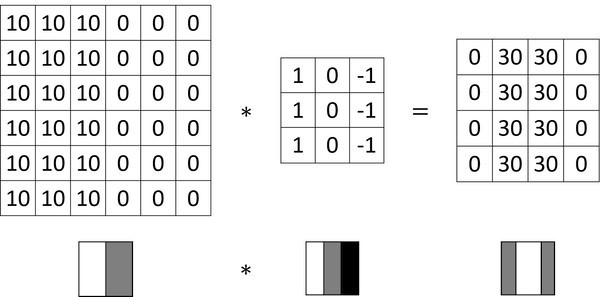

Source: Deep Learning Specialization by deeplearning.ai on Coursera

### Defining a Simple Example

Let's start by creating a very simple simple 4x4 greyscale image with an edge down the middle.

In [4]:
input = torch.tensor([
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
], dtype=torch.float)

print(input)
print(input.shape)

tensor([[10., 10., 10.,  0.,  0.,  0.],
        [10., 10., 10.,  0.,  0.,  0.],
        [10., 10., 10.,  0.,  0.,  0.],
        [10., 10., 10.,  0.,  0.,  0.],
        [10., 10., 10.,  0.,  0.,  0.],
        [10., 10., 10.,  0.,  0.,  0.]])
torch.Size([6, 6])


Now let's create an edge detection filter.

In [5]:
filter = torch.tensor([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=torch.float)

print(filter)
print(filter.shape)

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])
torch.Size([3, 3])


We reshape the input and filter to simulate an example with added dimensions for the images, channels and filters.
For the inputs, we want our new dimensions to be $(batch \_ size, channels, input \_ height, input\_width)$.
For the filters, we want our new dimensions to be $(out \_ channels, in \_ channels, input \_ height, input\_width)$.

In [6]:
input = input.unsqueeze(0).unsqueeze(0)
filter = filter.unsqueeze(0).unsqueeze(0)

print("inputs shape:", filter.shape)
print("filters shape:", filter.shape)

inputs shape: torch.Size([1, 1, 3, 3])
filters shape: torch.Size([1, 1, 3, 3])


The resulting shapes indicate that we have 
- 1 image with 1 color channel of size 6x6
- 1 filter with 1 color channel of size 3x3.

### Implementation using For Loops

We define a custom conv2d function that performs a 2D convolution operation on an input tensor using a specified filter, with options for padding and stride. It first calculates the shape of the output tensor based on the input dimensions, filter size, padding, and stride. It then pads the input tensor to handle the borders according to the specified padding. For each position in the output tensor, it iterates over the input tensor, extracts the relevant patch according to the current stride and filter size, and performs an element-wise multiplication of the filter with the patch across all input channels. The sum of these products for each filter is assigned to the corresponding position in the output tensor. This process is repeated for each image in the batch, producing a batch of filtered images.

In [7]:
def conv2d(input, filter, padding=0, stride=1):
    batch_size, in_channels, input_height, input_width = input.shape
    out_channels, _, filter_height, filter_width = filter.shape

    # Padding
    input_padded = F.pad(input, (padding, padding, padding, padding))

    # Calculate output dimensions
    output_height = (input_height + 2*padding - filter_height) // stride + 1
    output_width = (input_width + 2*padding - filter_width) // stride + 1

    # Placeholder for extracted patches from all images in the batch
    output = torch.zeros(size=(batch_size, out_channels, output_height, output_width))

    # Iterate over each image in the batch and the filter postitions
    for b in range(batch_size):
        for i in range(output_height):
            for j in range(output_width):
                # Calculate start and end indices for height and width
                start_i = i * stride
                end_i = start_i + filter_height
                start_j = j * stride
                end_j = start_j + filter_width

                # Extract the current patch from the padded input across all input channels
                current_patch = input_padded[b, :, start_i:end_i, start_j:end_j]

                output[b, :, i, j] = (current_patch * filter).sum(dim=(1, 2, 3))
    
    return output
    

### Vectorized Implementation

The following implementation optimizes the convolution operation using the im2col technique, which unfolds the input tensor into a matrix where each column corresponds to a patch of the input image. This transformation allows the convolution to be expressed as a matrix multiplication, significantly improving computational efficiency by leveraging optimized linear algebra routines. It starts by padding the input, calculating the output dimensions, and then iteratively extracting and reshaping each patch of the input image into columns of an unfolded tensor. This approach is preferred over traditional for-loop convolutions due to its ability to utilize parallel processing, leading to faster execution times, although it may increase memory usage due to the expanded representation of the input data.

In [8]:
padding=0
stride=1
# Assuming the kernel shape is (out_channels, in_channels, kernel_height, kernel_width)
batch_size, in_channels, in_height, in_width = input.shape
out_channels, _, filter_height, filter_width = filter.shape

# Calculate the output height and width
output_height = (in_height + 2 * padding - filter_height) // stride + 1
output_width = (in_width + 2 * padding - filter_width) // stride + 1

# Pad the input
input_padded = torch.nn.functional.pad(input, (padding, padding, padding, padding))

# Initialize the unfolded tensor for all patches
unfolded_tensor = torch.zeros((batch_size, in_channels * filter_height * filter_width, output_height * output_width))

# Extract patches
for i in range(output_height):
    for j in range(output_width):
        start_i = i * stride
        start_j = j * stride
        end_i = start_i + filter_height
        end_j = start_j + filter_width
        patches = input_padded[:, :, start_i:end_i, start_j:end_j]
        unfolded_tensor[:, :, i * output_width + j] = patches.reshape(batch_size, -1)


print("original input: ")
print(input)
print(input.shape)
print("unfolded input:")
print(unfolded_tensor)
print(unfolded_tensor.shape)

original input: 
tensor([[[[10., 10., 10.,  0.,  0.,  0.],
          [10., 10., 10.,  0.,  0.,  0.],
          [10., 10., 10.,  0.,  0.,  0.],
          [10., 10., 10.,  0.,  0.,  0.],
          [10., 10., 10.,  0.,  0.,  0.],
          [10., 10., 10.,  0.,  0.,  0.]]]])
torch.Size([1, 1, 6, 6])
unfolded input:
tensor([[[10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10.,
          10.,  0.],
         [10., 10.,  0.,  0., 10., 10.,  0.,  0., 10., 10.,  0.,  0., 10., 10.,
           0.,  0.],
         [10.,  0.,  0.,  0., 10.,  0.,  0.,  0., 10.,  0.,  0.,  0., 10.,  0.,
           0.,  0.],
         [10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10.,
          10.,  0.],
         [10., 10.,  0.,  0., 10., 10.,  0.,  0., 10., 10.,  0.,  0., 10., 10.,
           0.,  0.],
         [10.,  0.,  0.,  0., 10.,  0.,  0.,  0., 10.,  0.,  0.,  0., 10.,  0.,
           0.,  0.],
         [10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10., 10.,  0., 10., 10.,
 

As you can see in the result, we have each 3x3 filter position flattened and stacked row-wise in the output. Now we want to multiply each row by the filter and we should have an efficient implementation of convolution. 

For each image we have a matrix for the input and for the filters. So, to do the matrix multiplication we will use torch.bmm which performs a batch matrix-matrix product of matrices. 

For each individual image, our input shape is $(filter \_ positions, filter \_ height * filter \_ width)$. We want to matrix multiply each input image with the filter that is $(filter \_ height, filter \_ width)$. Therefore, we want to reshape the filter to make it shape $(filter \_ height * filter \_ width, 1)$. In this way, we get a valid matrix multiplication.

In [9]:
# Reshape filter for batch matrix multiplication
filter_reshaped = filter.view(out_channels, -1).unsqueeze(0).repeat(batch_size, 1, 1)
print(filter_reshaped)
print(filter_reshaped.shape)

tensor([[[ 1.,  0., -1.,  1.,  0., -1.,  1.,  0., -1.]]])
torch.Size([1, 1, 9])


In [10]:
# Perform matrix multiplication
# Result shape: (batch_size, out_channels, output_height * output_width)
output = torch.bmm(filter_reshaped, unfolded_tensor)

# Reshape the convolved output to the expected output shape
output = output.view(batch_size, out_channels, output_height, output_width)

print(output)
print(output.shape)

tensor([[[[ 0., 30., 30.,  0.],
          [ 0., 30., 30.,  0.],
          [ 0., 30., 30.,  0.],
          [ 0., 30., 30.,  0.]]]])
torch.Size([1, 1, 4, 4])


The result is a correct convolution of the the image. Let's put all the code into a function.

In [11]:
def conv2d_vectorized(input, filter, stride=1, padding=0):
    # Assuming the kernel shape is (out_channels, in_channels, kernel_height, kernel_width)
    batch_size, in_channels, in_height, in_width = input.shape
    out_channels, _, filter_height, filter_width = filter.shape
    
    # Calculate the output height and width
    output_height = (in_height + 2 * padding - filter_height) // stride + 1
    output_width = (in_width + 2 * padding - filter_width) // stride + 1
    
    # Pad the input
    input_padded = torch.nn.functional.pad(input, (padding, padding, padding, padding))
    
    # Initialize the unfolded tensor for all patches
    unfolded_tensor = torch.zeros((batch_size, in_channels * filter_height * filter_width, output_height * output_width))
    
    # Extract patches
    for i in range(output_height):
        for j in range(output_width):
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + filter_height
            end_j = start_j + filter_width
            patches = input_padded[:, :, start_i:end_i, start_j:end_j]
            unfolded_tensor[:, :, i * output_width + j] = patches.reshape(batch_size, -1)
    
    # Reshape kernel for matrix multiplication
    filter_reshaped = filter.view(out_channels, -1).unsqueeze(0).repeat(batch_size, 1, 1)
    
    # Perform matrix multiplication
    # Result shape: (batch_size, out_channels, output_height * output_width)
    output = torch.bmm(filter_reshaped, unfolded_tensor)
    
    # Reshape the convolved output to the expected output shape
    output = output.view(batch_size, out_channels, output_height, output_width)
    
    return output

### Checking the Implementations

We test the function and see whether it's result is the same as PyTorch's built in function.

In [12]:
import time

# Initialize the same input and filters as for your custom conv2d function
input = torch.randn(10, 3, 64, 64)  # batch_size=2, in_channels=3, height=8, width=8
filter = torch.randn(32, 3, 3, 3)  # out_channels=4, in_channels=3, height=3, width=3
batch_size, in_channels, input_height, input_width = input.shape
out_channels, in_channels, filter_height, filter_width = filter.shape

# Timing custom conv2d function
start_time = time.time()
output_custom = conv2d(input, filter)
end_time = time.time()
time_custom = end_time - start_time

# Timing custom conv2d_vectorized function
start_time = time.time()
output_vectorized = conv2d_vectorized(input, filter)
end_time = time.time()
time_custom_vectorized = end_time - start_time

# Using PyTorch's built-in Conv2d
conv_layer = nn.Conv2d(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=filter_height,
    bias=False,
)
# Manually set the weights of the Conv2d layer to match our filters
conv_layer.weight.data = filter

# Compute the output using the built-in Conv2d
# Timing built-in Conv2d
start_time_builtin = time.time()
output_builtin = conv_layer(input)
end_time_builtin = time.time()
time_builtin = end_time_builtin - start_time_builtin

# Check if the outputs are close enough
are_close = torch.allclose(output_vectorized, output_builtin, atol=1e-5)
print(f"Are the custom and built-in conv2d outputs close? {are_close}")

# Print timing results
print(f"Custom function took: {time_custom:.6f} seconds")
print(f"Custom vectorized function took: {time_custom_vectorized:.6f} seconds")
print(f"PyTorch took: {time_builtin:.6f} seconds")

Are the custom and built-in conv2d outputs close? True
Custom function took: 1.838982 seconds
Custom vectorized function took: 0.134127 seconds
PyTorch took: 0.002676 seconds


## Max Pooling Function

In [13]:
def maxpool2d(input, kernel_size=2, stride=2, padding=0):
    batch_size, in_channels, input_height, input_width = input.shape

    # Calculate output dimensions
    output_height = (input_height + 2*padding - filter_height) // stride + 1
    output_width = (input_width + 2*padding - filter_width) // stride + 1

    # Placeholder for the output
    output = torch.zeros(size=(batch_size, in_channels, output_height, output_width))

    # Padding
    input_padded = F.pad(input, (padding, padding, padding, padding))

    # Iterate over each image in the batch and the filter positions
    for b in range(batch_size):
        for c in range(in_channels):
            for i in range(output_height):
                for j in range(output_width):
                    # Calculate start and end indices for height and width
                    start_i = i * stride
                    end_i = start_i + kernel_size
                    start_j = j * stride
                    end_j = start_j + kernel_size

                    # Extract the current patch from the padded input
                    current_patch = input_padded[b, c, start_i:end_i, start_j:end_j]

                    # Apply max pooling to the current patch
                    output[b, c, i, j] = current_patch.max()
    
    return output
    

In [14]:
def maxpool2d_vectorized(input, kernel_size=2, stride=2, padding=0):
    batch_size, in_channels, in_height, in_width = input.shape
    
    # Calculate the output height and width
    output_height = (in_height + 2 * padding - kernel_size) // stride + 1
    output_width = (in_width + 2 * padding - kernel_size) // stride + 1
    
    # Pad the input
    input_padded = F.pad(input, (padding, padding, padding, padding))
    
    # Initialize the unfolded tensor for all patches
    unfolded_tensor = torch.zeros((batch_size, in_channels, kernel_size * kernel_size, output_height * output_width))
    
    # Extract patches
    for i in range(output_height):
        for j in range(output_width):
            start_i = i * stride
            start_j = j * stride
            end_i = start_i + kernel_size
            end_j = start_j + kernel_size
            patches = input_padded[:, :, start_i:end_i, start_j:end_j]
            unfolded_tensor[:, :, :, i * output_width + j] = patches.reshape(batch_size, in_channels, -1)
    
    # Perform max pooling
    pooled_output = unfolded_tensor.max(dim=2)[0]
    
    # Reshape the pooled output to the expected output shape
    pooled_output = pooled_output.view(batch_size, in_channels, output_height, output_width)
    
    return pooled_output

In [15]:
# Generate a test input tensor
input = torch.randn(30, 3, 64, 64)  # Example shape: batch_size=1, channels=3, height=32, width=32

# Apply Custom Max Pooling
start_custom = time.time()
custom_output = maxpool2d(input, kernel_size=2, stride=2)
end_custom = time.time()

# Apply Vectorized Custom Max Pooling
start_vectorized = time.time()
custom_output = maxpool2d_vectorized(input, kernel_size=2, stride=2)
end_vectorized = time.time()

# Apply PyTorch Max Pooling
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
start_pytorch = time.time()
pytorch_output = maxpool(input)
end_pytorch = time.time()

# Compare Outputs
are_close = torch.allclose(custom_output, pytorch_output, atol=1e-6)
print(f"Are the outputs close? {are_close}")

# Measure and Compare Performance
print(f"Custom Max Pooling Time: {end_custom - start_custom:.6f} seconds")
print(f"Vectorized Max Pooling Time: {end_vectorized - start_vectorized:.6f} seconds")
print(f"PyTorch Max Pooling Time: {end_pytorch - start_pytorch:.6f} seconds")

Are the outputs close? True
Custom Max Pooling Time: 2.517624 seconds
Vectorized Max Pooling Time: 0.047944 seconds
PyTorch Max Pooling Time: 0.001001 seconds


## Data Loading and Preprocessing

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
# Add single dimension for the input channel
X_train = X_train.unsqueeze(1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
# Add single dimension for the input channel
X_val = X_val.unsqueeze(1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

### Single Batch Iteration

In [17]:
def relu(x):
    out = torch.maximum(x, torch.zeros(1))
    return out

def softmax(X):
    X_exp = torch.exp(X)
    X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
    return X_softmax

def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

def calculate_same_padding(input_size, kernel_size, stride):
    if input_size % stride == 0:
        pad_total = max(kernel_size - stride, 0)
    else:
        pad_total = max(kernel_size - (input_size % stride), 0)
    padding = pad_total // 2
    return padding

In [18]:
# Create a batch
batch_size = 128
perm = torch.randperm(len(X_train))
X_batch = X_train[perm][:batch_size]
y_batch = y_train[perm][:batch_size]

batch_size, in_channels, input_height, input_width = X_batch.shape

filter_size = 3 # Filter size for all layers
pool_size = 2 # Pool size for all layers

# CONV + POOL Layer 1
out_channels1 = 16 # Number of filters in the first conv layer
W1 = nn.Parameter(torch.randn(out_channels1, in_channels, filter_size, filter_size) * 0.01)
b1 =  nn.Parameter(torch.zeros(size=(1, out_channels1, 1, 1)))
# After Conv1 + Same Padding + Stride 1 => Shape remains [batch_size, out_channels1, input_height, input_width]
# After Pooling1 with pool_size 2 and stride 2 => Shape: [batch_size, out_channels1, input_height/2, input_width/2]

# CONV + POOL Layer 2
out_channels2 = 32 # Number of filters in the second conv layer
W2 = nn.Parameter(torch.randn(out_channels2, out_channels1, filter_size, filter_size) * 0.01)
b2 = nn.Parameter(torch.zeros(size=(1, out_channels2, 1, 1)))
# After Conv2 + Same Padding + Stride 1 => Shape: [batch_size, out_channels2, input_height/2, input_width/2]
# After Pooling2 with pool_size 2 and stride 2 => Shape: [batch_size, out_channels2, input_height/4, input_width/4]

# FC Layer
# Before the FC layer, the output from the last pooling layer is flattened
# Flattened shape: [batch_size, out_channels2 * (input_height/4) * (input_width/4)]
num_classes = 10  # For example, in a classification problem with 10 classes
# Initialize the fc layer weights
W3 = nn.Parameter(torch.randn(out_channels2 * int(input_height/4 * input_height/4), num_classes) * 0.01)
b3 = nn.Parameter(torch.zeros(num_classes))
# The FC layer maps from the flattened size to the number of classes
# After FC => Shape: [batch_size, num_classes]

parameters = [W1, b1, W2, b2, W3, b3]
optimizer = SGDScratch(parameters, lr=0.1)

# Zero gradients
optimizer.zero_grad()

# CONV + POOL Layer 1
padding = calculate_same_padding(input_height, filter_size, 1)
Z1 = conv2d_vectorized(X_batch, W1, padding=padding) + b1
A1 = relu(Z1)
P1 = maxpool2d_vectorized(A1, kernel_size=pool_size, stride=2)

# CONV + POOL Layer 2
padding = calculate_same_padding(P1.size(3), filter_size, 1)
Z2 = conv2d_vectorized(P1, W2, padding=padding) + b2
A2 = relu(Z2)
P2 = maxpool2d_vectorized(A2, kernel_size=pool_size, stride=2)

# FC Layer
P2_flat = P2.flatten(start_dim=1)
Z3 = P2_flat @ W3 + b3
y_pred = softmax(Z3)

# Calculate Loss
loss = log_loss(y_pred, y_batch)

# Compute gradients
loss.backward()

# Update parameters
optimizer.step()

In [19]:
# Zero gradients
optimizer.zero_grad()

# CONV + POOL Layer 1
padding = calculate_same_padding(input_height, filter_size, 1)
Z1 = conv2d_vectorized(X_batch, W1, padding=padding) + b1
A1 = relu(Z1)
P1 = maxpool2d_vectorized(A1, kernel_size=pool_size, stride=2)

# CONV + POOL Layer 2
padding = calculate_same_padding(P1.size(3), filter_size, 1)
Z2 = conv2d_vectorized(P1, W2, padding=padding) + b2
A2 = relu(Z2)
P2 = maxpool2d_vectorized(A2, kernel_size=pool_size, stride=2)

# FC Layer
P2_flat = P2.flatten(start_dim=1)
Z3 = P2_flat @ W3 + b3
y_pred = softmax(Z3)

# Calculate Loss
loss = log_loss(y_pred, y_batch)

# Compute gradients
loss.backward()

# Update parameters
optimizer.step()
